# Getting an Edge with Network Analysis in Python - A Gentle Introduction

This notebook contains the code that was presented at the PyData Berlin virtual meetup on May 20th 2020 by [@alonnir](https://github.com/alonnir).

If you're interested in learning more about network analysis, you might find my repo **[SNAcks](https://github.com/alonnir/snacks)** useful. It's a 'human friendly' curated list of top quality resources on the subject. Check it out ;).

Video link will be added once it's up.

This is where we left off in the deck:

<img src="images/slide.png" alt="venmo" width="800">

In [1]:
import networkx as nx
print(nx.__version__)

import pandas as pd
import collections

import matplotlib.pyplot as plt
%matplotlib inline

from utils.pos import pos

from IPython.display import Image

2.4


In [2]:
# Create an empty graph (no nodes and no edges)
G = nx.Graph()

> In NetworkX, nodes can be any hashable object e.g., a text string, an image, an XML object, another Graph, a customized node object, etc.


([docs](https://networkx.github.io/documentation/stable/tutorial.html#creating-a-graph))


#### Populate the Graph

We can pass a list of tuples (node1, node2) and networkx will interpert each tuple as <br>
having an edge between (or from, in directed graphs) node1 and node2.

In [3]:
G.add_edges_from([('Leonard', 'Jon'),
                 ('Hunter', 'Brian'),
                 ('Ericka', 'Monica')])

We just created our first network - that was easy! <br>
Let's see what it looks like

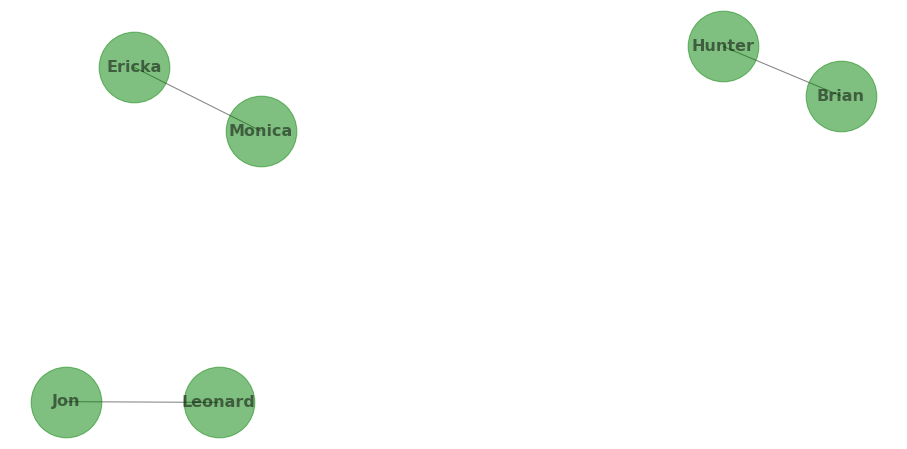

In [4]:
plt.figure(figsize=(16,8), frameon=False)

limits = plt.axis('off')


nx.draw_networkx(G,                              # our graph
                 node_size=5000,                 # just so it's easier to read
                 font_size=16,
                 font_weight='bold',
                 node_color='g', alpha=.5,
                 pos=nx.spring_layout(G, k=.8)) # spread the nodes for legibility

## We created our first network...
## but it is not super exciting

Here's what we'll do then:

1. Create a large network from a bigger data set<br>
2. We'll break the large graph to smaller independent sub-graphs (connected-components)<br>
3. We'll zoom in on one _connected-component_<br>
4. We'll discover _communities_ withing that connected component.<br>
5. Finally we'll zoom in to interesting individuals<br>

In other words:

Large Graph<br>
⬇️<br>
one subgraph<br>
⬇️<br>
communities<br>
⬇️<br>
individuals

## Load Bigger Data

Notes:

+ We'll use Pandas (<3), other raw data formats NetworkX handles well include Pickle, JSON. [(docs)](https://networkx.github.io/documentation/stable/reference/readwrite/index.html)<br><br>

+ For simplicity, we are going to create a _directed_ graph, while in reality a better structure would have been a [_multi directed_ graph](https://networkx.github.io/documentation/stable/reference/classes/multidigraph.html) since the same users can (and do) interact with each other multiple times. A good followup exercise after finishing this introduction is to generate more data for interactions between two ids, create a MultiDiGraph and see how results change. Another followup could be to add a randomly drawn payment amount per transaction, and use that data as [edge weights](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_weighted_graph.html).<br><br>

+ Data used here was obfuscated and anonymised. 

In [5]:
pmts_df = pd.read_csv('data/p2p_payments.csv', usecols=['sender_id', 'receiver_id'])

In [6]:
print(pmts_df.shape)
pmts_df.head()

(637561, 2)


,sender_id,receiver_id
0,1234611,9347154
1,1234758,1235004
2,1240786,28998678
3,1242002,7883495
4,1246390,2510844


In [7]:

G = nx.from_pandas_edgelist(pmts_df,                       # DataFrame with raw data
                            source='sender_id',            # From.. (some dataframes have more than 2 columns...)
                            target='receiver_id',          # To..
                            create_using=nx.DiGraph())     # <== This is a Directed Graph (technically, a MultiDiGraph, but we'll get to that later)


# Let's see what we're working with
# (you can also use nx.info(G))

print(nx.number_of_nodes(G), 'nodes (= people)')
print(nx.number_of_edges(G), 'edges (= $ transfer)')
print(nx.number_of_isolates(G), 'isolates - nodes with no neighbours')

709625 nodes (= people)
637560 edges (= $ transfer)
0 isolates - nodes with no neighbours


### Visualizing the Large Network

(static image to save resources)

<img src="images/large_graph.png" alt="drawing" width="800">

This is not very helpful.. what can we do?
+ We can visualize and analyse the large network with NetworkX and/or external tools
+ We can zoom in on one 'sub group' of this large network and see if we can find something interesting there.

We'll go with the second option:
+ Easier to gain intuitive understanding of some of the concepts as it’s easier to see. 
+ Larger networks are less intuitive and more resource heavy.

The way to look at a 'sub group' is with:

## Connected Components

A connected component is a subset of the nodes of the graph such that:
+ There is a _path_ between any two nodes of the subset.
+ No other node in the graph has a path to any of the nodes in the subset.

<img src="images/cc.png" alt="venmo" width="700">

However, if we cut just one edge out:

<img src="images/cc2.png" alt="venmo" width="700">

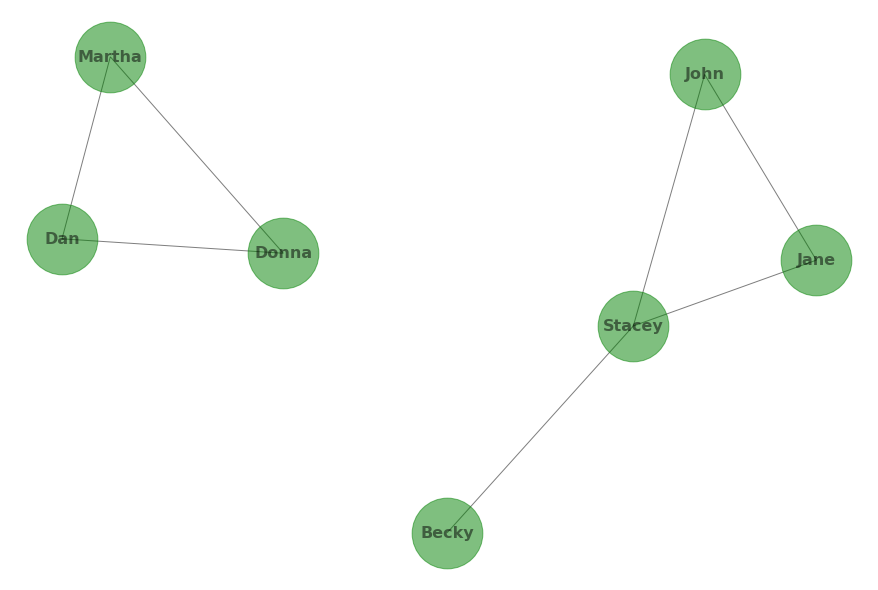

In [8]:
# CC - asimple example


Gcc = nx.Graph([('John', 'Stacey'), ('Stacey', 'Becky'), ('John', 'Jane'), ('Jane', 'Stacey'),
               
               ('Dan', 'Donna'), ('Donna', 'Martha'), ('Dan', 'Martha')])

plt.figure(figsize=(12,8), frameon=False)

nx.draw(Gcc, 
        with_labels=True,
        node_size=5000,                 # just so it's easier to read
        font_size=16,
        font_weight='bold',
        node_color='g', alpha=.5,
        pos=nx.spring_layout(Gcc, k=1))

Back to our data...

In [9]:
WCC = nx.weakly_connected_components(G)  # returns a generator

WCC = list(WCC)

# To explore what CCs were created:
lens = map(len, WCC)
d = collections.Counter(lens)

print('The largest connected component is {} members strong.'.format(max(d.keys())))

The largest connected component is 18630 members strong.


In [10]:
print('Top 5 largest connected components:')
sorted(d.items(), key=lambda pair: pair[0], reverse=True)[:5]

Top 5 largest connected components:


[(18630, 1), (1850, 1), (1573, 1), (1215, 1), (806, 1)]

In [11]:
# We'll zoom in on one CC which I conveniently cherry picked beforehand 

cherry_picked = [89982092, 181864420, 26883318, 179460632, 173813279, 201580336, 80169798, 149545813, 132912902, 
                 158371685, 89206696, 94320305, 141096635, 110435538, 90591708, 153781494, 41199144, 166174518, 
                 157400135, 138095203, 71531372, 52092024, 133876398, 83288263, 130938831, 163773408, 136554234, 
                 144764238, 118387306, 172112863, 69972730, 64956422, 145865230, 135149099, 57951059, 114323615, 
                 36183602, 172968741, 55881564, 136552311]

We'll now create a **Subgraph**.<br>
A [subgraph](https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html) is essentially a 'subset' of the original (Supergraph) for given nodes.<br>
If we pass a list of nodes, networkx knows to take the relevant edges and information (direction, weights, attributes...) from the Supergraph.

In [12]:
Gsub = G.subgraph(nodes=cherry_picked)

print(nx.number_of_nodes(Gsub), 'nodes')
print(nx.number_of_edges(Gsub), 'edges')

40 nodes
78 edges


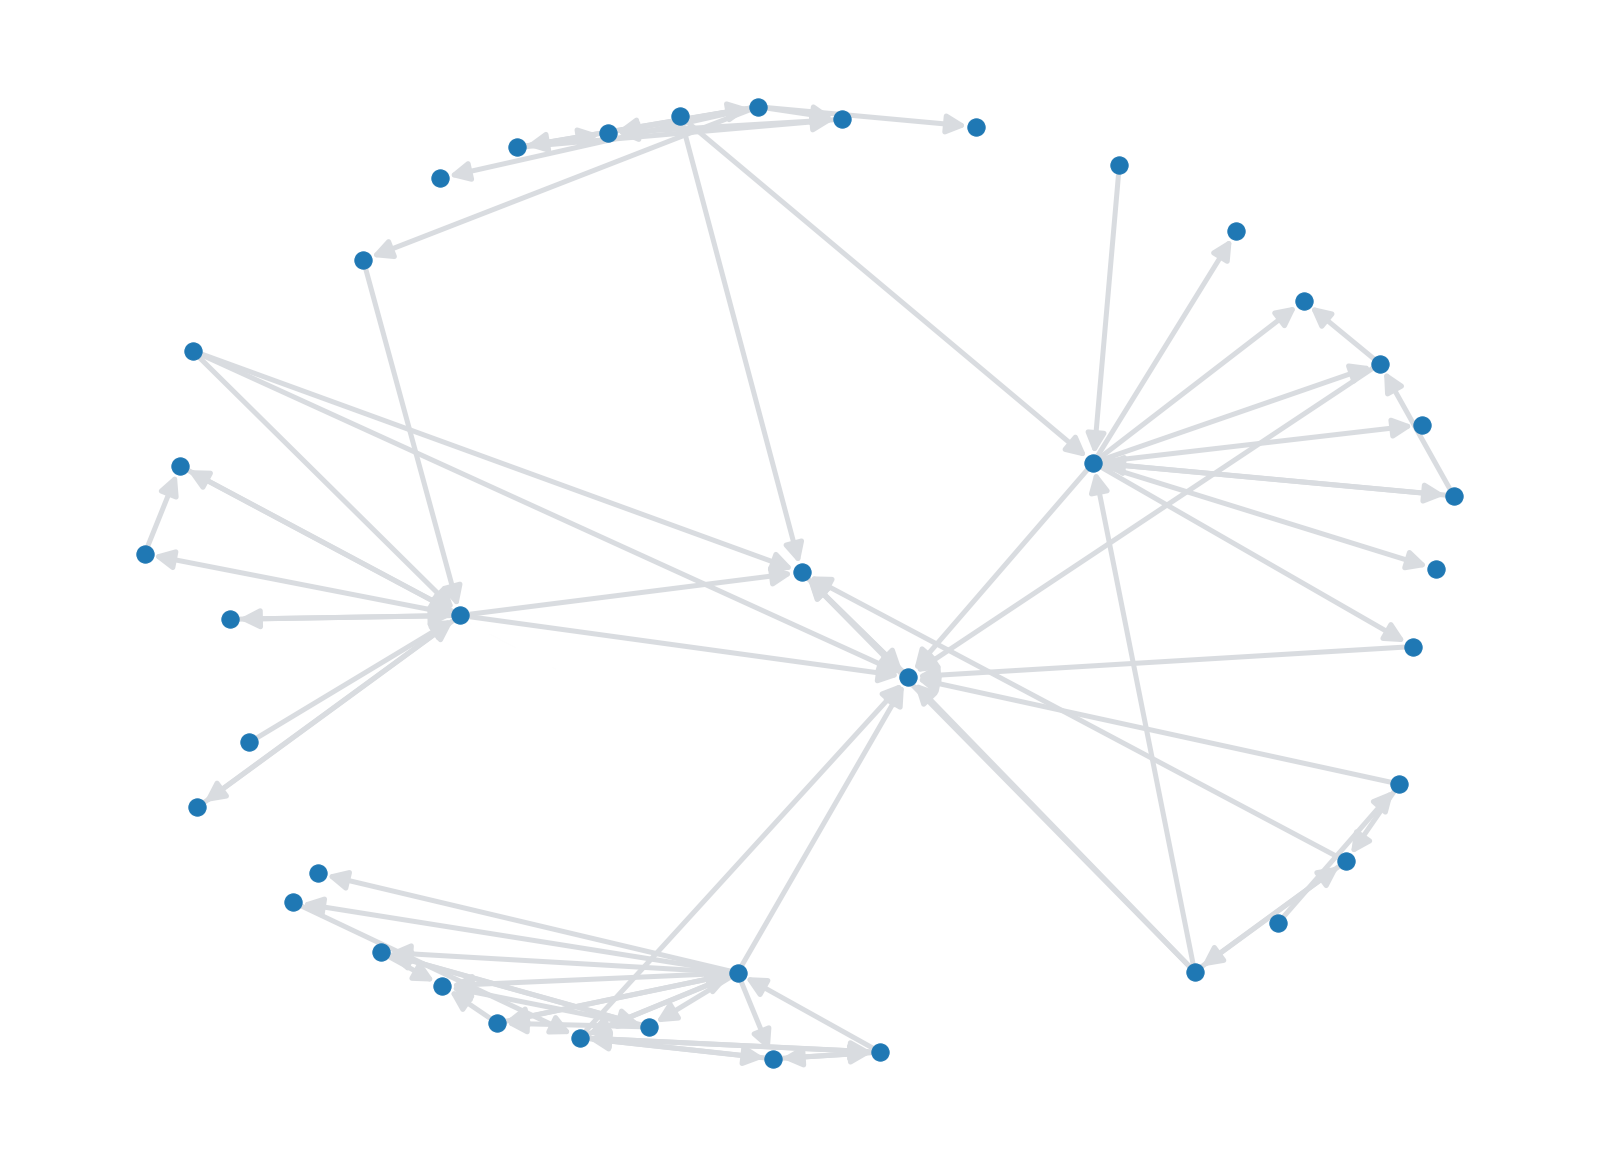

In [13]:
# let's see what that subgraph looks like!

plt.figure(figsize=(22,16))


nx.draw(Gsub, 
        edge_color='#d9dce0',
        width=5,
        pos=pos,         # positions of the nodes, preconfigured earlier 
        arrowsize=40)  

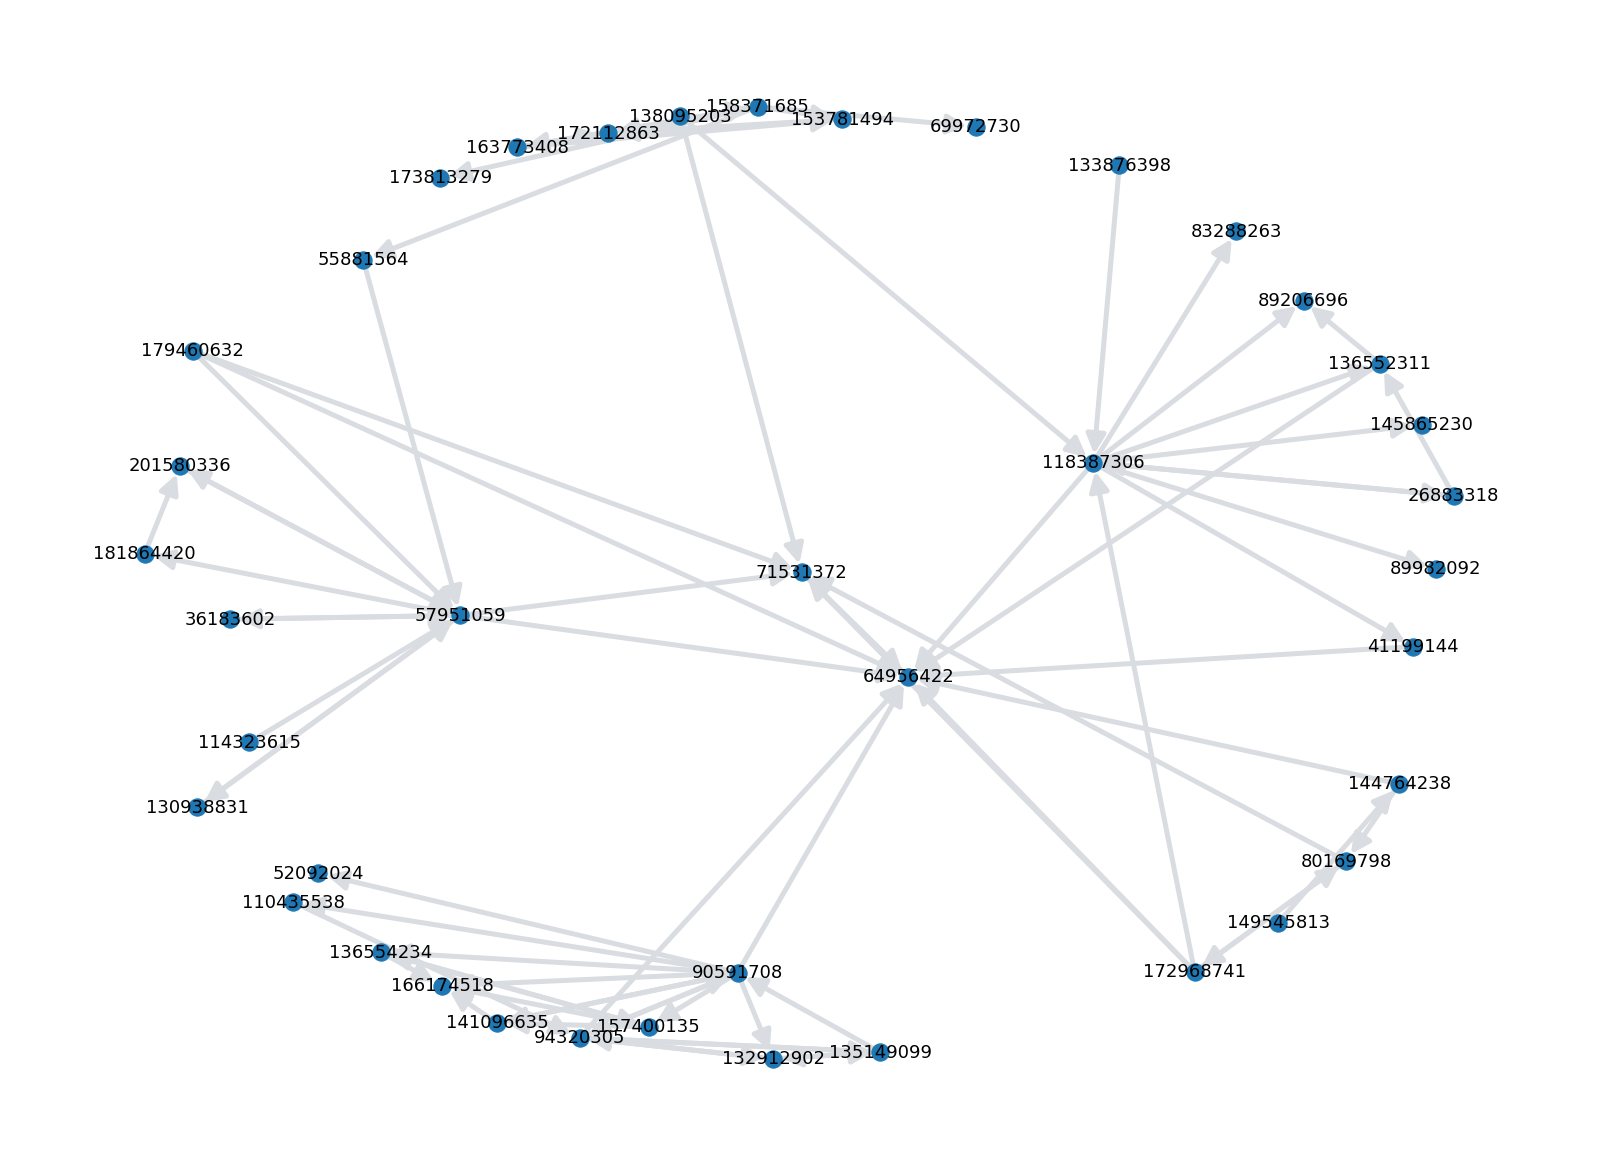

In [14]:
# Add user ids

plt.figure(figsize=(22,16))


nx.draw(Gsub, 
        edge_color='#d9dce0',
        width=5,
        font_size=18, 
        pos=pos, 
        arrowsize=40,
        with_labels=True)  # <====

User IDs are very impersonal.. let's add some names.

### Add Node Attributes

Note: To add node attributes here we'll read info on our users from a smaller dataframe that holds info just for the connected componenet we're focusing in. This is done to save space in the original DataFrame and also to illustrate that additional info can be appended from other sources.

In [15]:
node_atts_df = pd.read_csv('data/node_attributes.csv', index_col='userid')

node_atts_df.head()

,first_name,gender
userid,,
89982092,Feliza,Female
181864420,Sheilah,Female
26883318,Joy,Female
179460632,Keefe,Male
173813279,Sanford,Male


In [16]:
# Turn that to a dict, gotta <3 pandas
node_atts_d = node_atts_df.to_dict(orient='index')


# and apply - a little long but it works!
nx.classes.function.set_node_attributes(Gsub, node_atts_d)

In [17]:
# let's see that attributes were set

Gsub.nodes[89982092]

{'first_name': 'Feliza', 'gender': 'Female'}

In [18]:
# we can access the node attributes by:
# Gsub.nodes.data()

# or a specific attribute by a key
nx.get_node_attributes(Gsub, 'first_name')

{132912902: 'Neils',
 64956422: 'Todd',
 89982092: 'Feliza',
 145865230: 'Isidora',
 179460632: 'Keefe',
 173813279: 'Sanford',
 114323615: 'Leandra',
 172968741: 'Binnie',
 89206696: 'Cecil',
 41199144: 'Berti',
 135149099: 'Ansel',
 133876398: 'Damaris',
 201580336: 'Ardeen',
 94320305: 'Marleah',
 36183602: 'Danita',
 166174518: 'Lonnard',
 141096635: 'Roze',
 80169798: 'Lesya',
 157400135: 'Karon',
 83288263: 'Ulberto',
 144764238: 'Pattin',
 130938831: 'Madalyn',
 69972730: 'Jessica',
 136552311: 'Al',
 110435538: 'Sabine',
 57951059: 'Lincoln',
 149545813: 'Robbie',
 90591708: 'Julius',
 55881564: 'Fannie',
 172112863: 'Lewie',
 163773408: 'Liz',
 138095203: 'Martie',
 181864420: 'Sheilah',
 158371685: 'Millicent',
 118387306: 'Tito',
 71531372: 'Brandon',
 26883318: 'Joy',
 153781494: 'Brand',
 52092024: 'Carce',
 136554234: 'Dyan'}

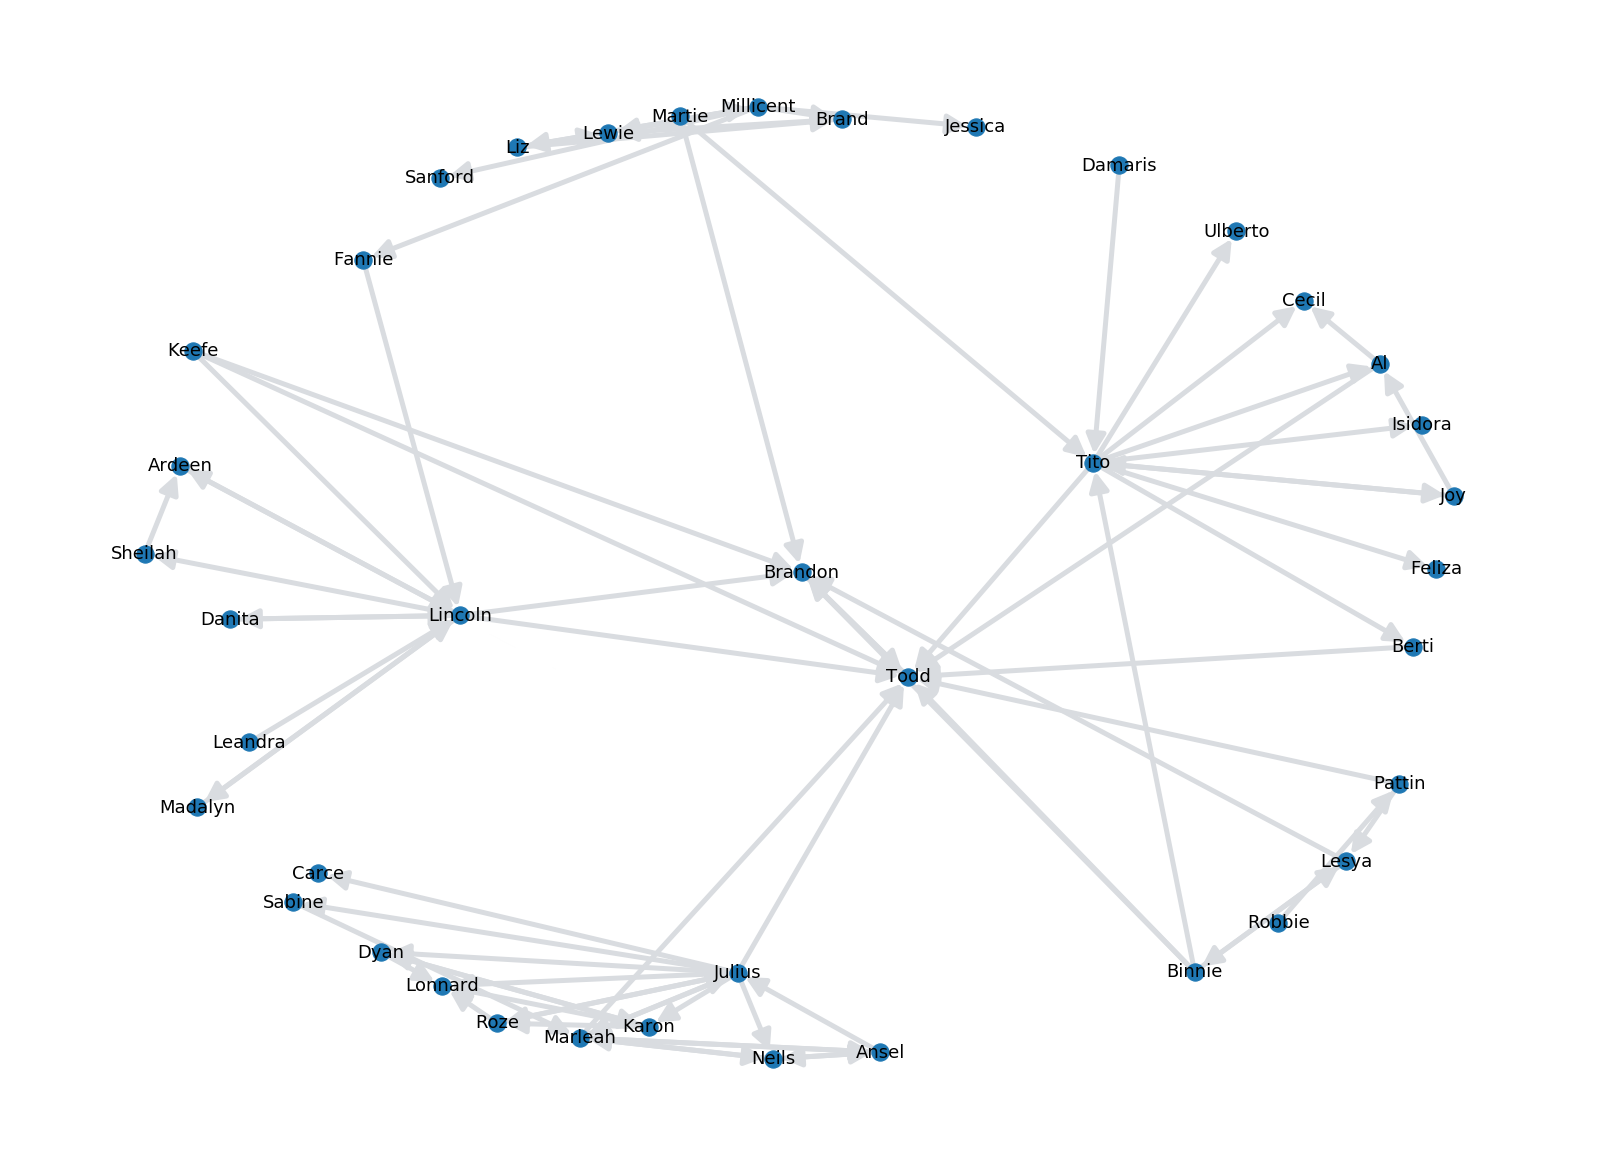

In [19]:
plt.figure(figsize=(22,16))

node_lables = nx.get_node_attributes(Gsub, 'first_name')  # <==== (graph, attribute)

nx.draw(Gsub, 
        edge_color='#d9dce0',
        width=5,
        font_size=18, 
        pos=pos, 
        arrowsize=40,
        labels=node_lables, # <====
        with_labels=True)  

### Checkpoint

✅Large Graph (~700k nodes)<br> 

✅one subgraph (~40 nodes)<br>

Next: <br>

+ communities<br>

+ individuals

## Detecting Communities

Very high level: 

Communities tend to have dense connections between the nodes within a community, but sparse connections between nodes in different communities.

(you have your group of friends, other people have their own; you are not part of theirs and they are not a part of yours).

Different from connected components, where there are no paths connecting one component to another.

In [20]:
import community

# Not bundled in NetworkX.
# Uses Louvain algorithm. 
# pip install python-louvain

# Alternatively: nx.algorithms.community.centrality.girvan_newman(Gsub), uses Girvan-Newman algorithm

communities = community.best_partition(Gsub.to_undirected(), resolution=.75)  # cheating a little bit here too, by passing an undirected graph..

c_values = [communities.get(node) for node in Gsub.nodes()]

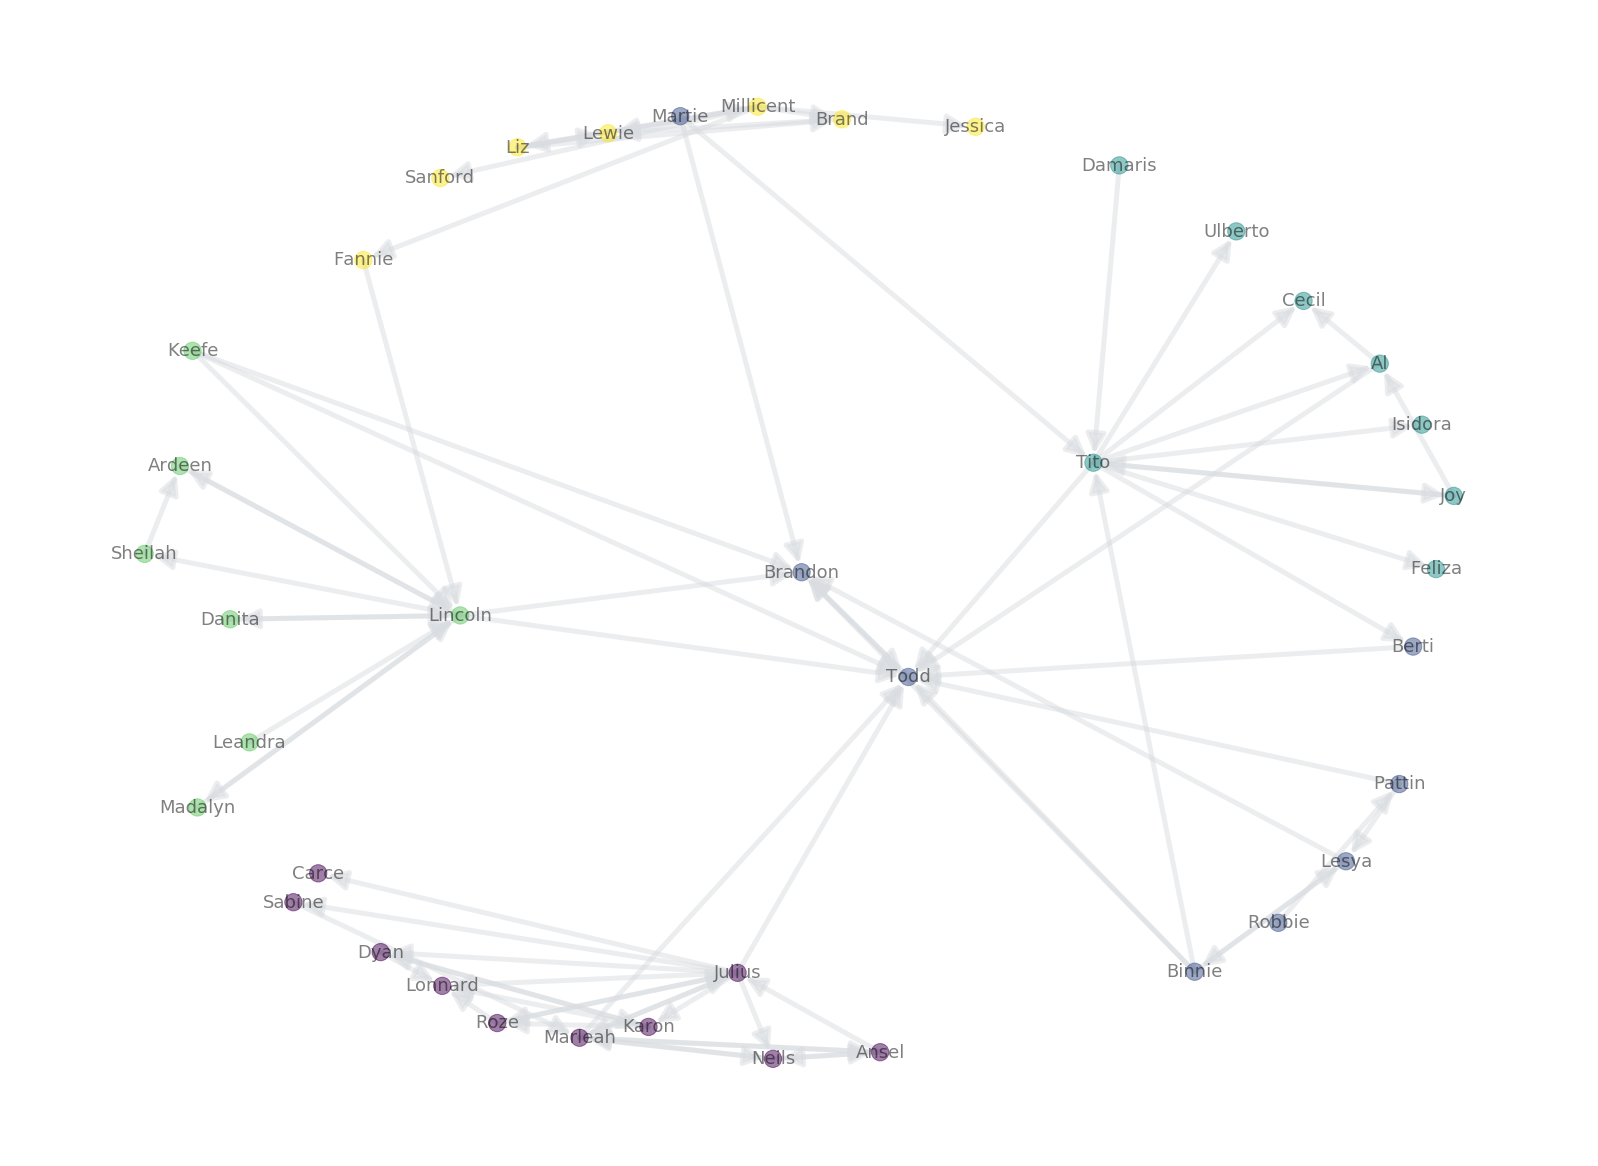

In [21]:
plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=18, 
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize=40,
        labels=node_lables,
        with_labels=True)

## Ranking our Nodes

There are many ways to rank and 'score' nodes. <br>
There is no one right way - depends on context and goal.<br>

Some ways include:

#### Naïve:
* Degree Centrality: The degree centrality for a node is the fraction of other nodes in the graph it is connected to.
* In/Out Degree Centrality: similarly, when considering incoming/outgoing links.

#### A little more complex:
Not all nodes are created equal!
+ Betweeness Centrality
+ PageRank
+ (HITS)

#### Betweeness Centrality

One of the most common and important centrality measures for nodes, and for good reason.

> Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through v. 

[(docs)](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

That's a lot to take in, and I spared you the mathematical formulation.


Intuitivly:

+ We saw that a 'path' is edge(s) that connect a given node to another given node (without repetition)
+ Shortest path between two nodes is the 'cheapest' way to get from one node to the other (the way with least edges, or for weighted graphs - lowest sum of weights).
+ Central nodes in a network have more shortest paths go through them then other nodes.



For large graphs we can approximate the BC.

In [22]:
bc = nx.centrality.betweenness.betweenness_centrality(Gsub)

bc

{132912902: 0.001349527665317139,
 64956422: 0.009446693657219972,
 89982092: 0.0,
 145865230: 0.0,
 179460632: 0.0,
 173813279: 0.0,
 114323615: 0.0,
 172968741: 0.016531713900134953,
 89206696: 0.0,
 41199144: 0.0,
 135149099: 0.002361673414304993,
 133876398: 0.0,
 201580336: 0.0033738191632928472,
 94320305: 0.012483130904183536,
 36183602: 0.0,
 166174518: 0.0,
 141096635: 0.010796221322537112,
 80169798: 0.01282051282051282,
 157400135: 0.006072874493927126,
 83288263: 0.0,
 144764238: 0.008097165991902834,
 130938831: 0.0,
 69972730: 0.0,
 136552311: 0.0010121457489878543,
 110435538: 0.0,
 57951059: 0.03171390013495277,
 149545813: 0.0,
 90591708: 0.03171390013495277,
 55881564: 0.009446693657219972,
 172112863: 0.0,
 163773408: 0.0,
 138095203: 0.0,
 181864420: 0.0,
 158371685: 0.0067476383265856945,
 118387306: 0.033738191632928474,
 71531372: 0.0006747638326585695,
 26883318: 0.0,
 153781494: 0.0,
 52092024: 0.0,
 136554234: 0.0}

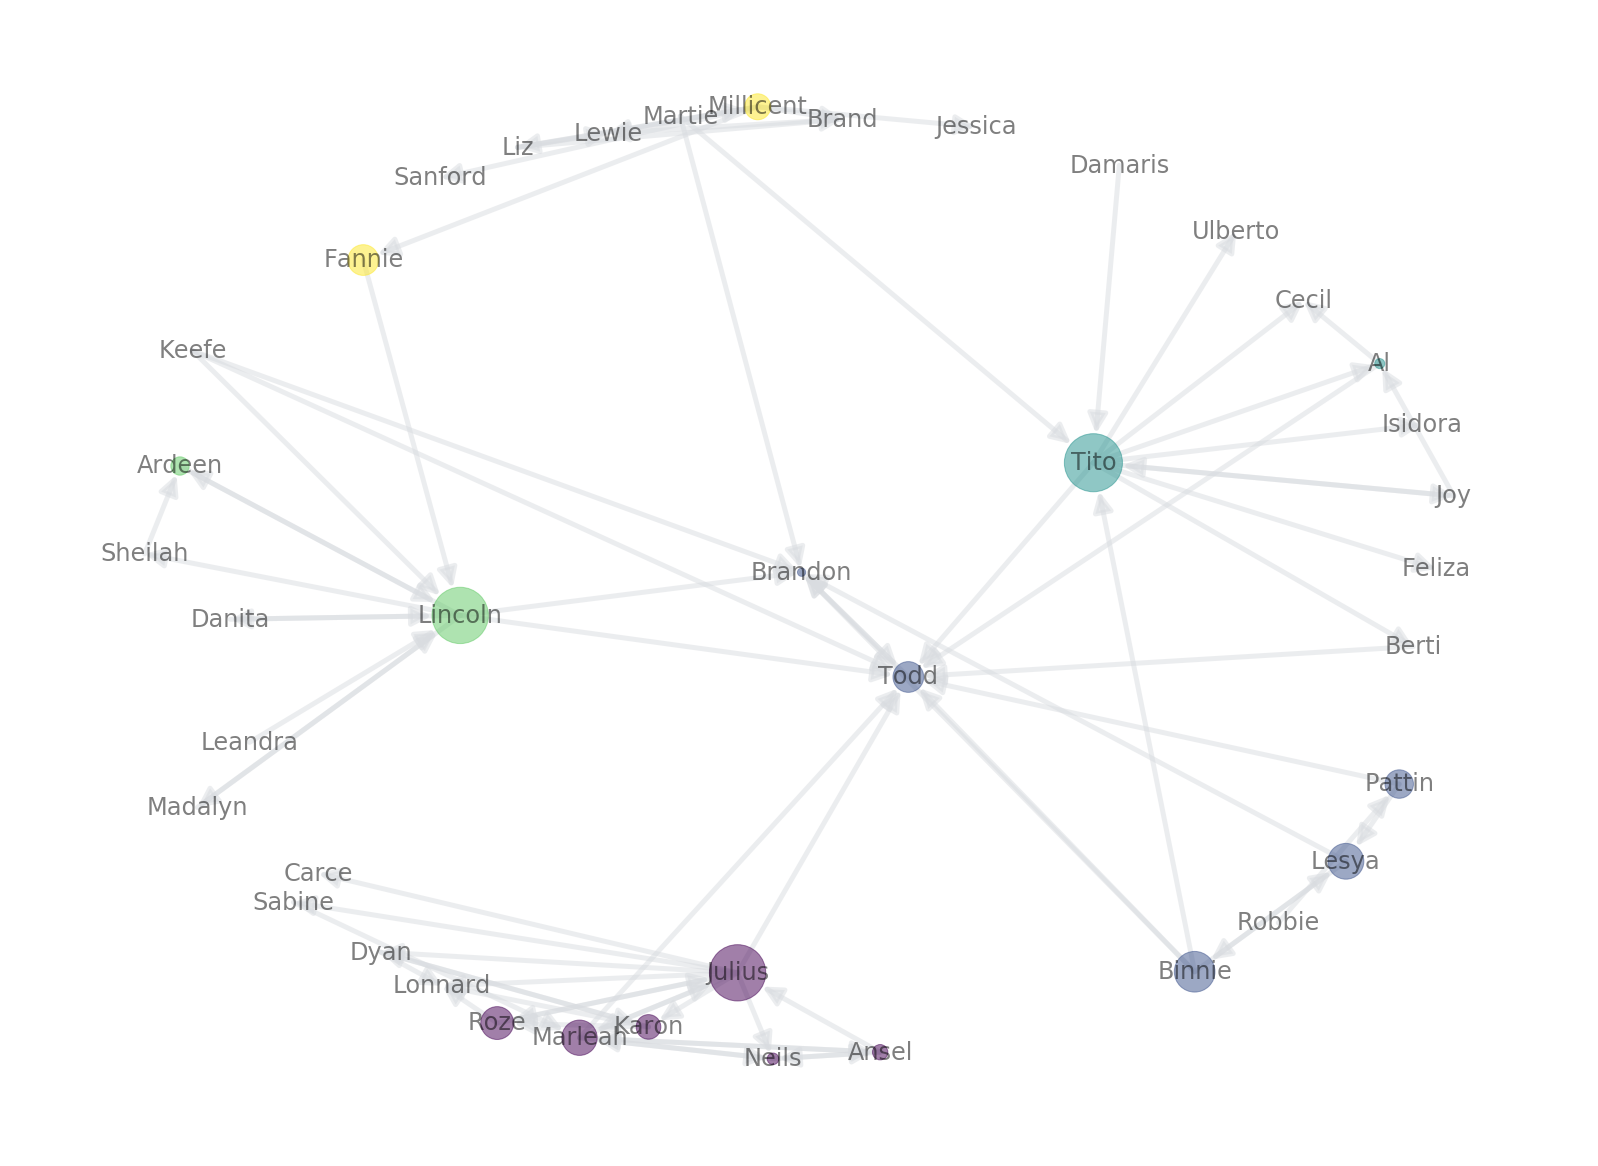

In [23]:
plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=24, 
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*bc[n] for n in Gsub.nodes()])   # <=== so easy!

### PageRank

> PageRank works by counting the **number** and **quality** of links to a page to determine a rough estimate of how important the website is. <br>The underlying assumption is that more important websites are likely to receive more links from other websites.

(Source: [wikipedia](https://en.wikipedia.org/wiki/PageRank)).

In [24]:
pr = nx.pagerank(Gsub)

pr

{132912902: 0.019743321778779858,
 64956422: 0.24827487278289415,
 89982092: 0.007765041620791972,
 145865230: 0.007765041620791972,
 179460632: 0.0057682510274736,
 173813279: 0.006860806611589982,
 114323615: 0.0057682510274736,
 172968741: 0.011154673548052286,
 89206696: 0.012467753201747027,
 41199144: 0.007765041620791972,
 135149099: 0.020266026475773177,
 133876398: 0.0057682510274736,
 201580336: 0.02875705596316821,
 94320305: 0.028737762599363524,
 36183602: 0.015544288049684702,
 166174518: 0.02130868585880962,
 141096635: 0.011518189668991846,
 80169798: 0.012673917418194418,
 157400135: 0.01278968140456339,
 83288263: 0.007765041620791972,
 144764238: 0.01067126931719339,
 130938831: 0.015544288049684702,
 69972730: 0.006860806611589982,
 136552311: 0.011065188411346526,
 110435538: 0.007894433309654501,
 57951059: 0.06900659968094996,
 149545813: 0.0057682510274736,
 90591708: 0.02251238759150785,
 55881564: 0.006860806611589982,
 172112863: 0.016288711136853984,
 163773

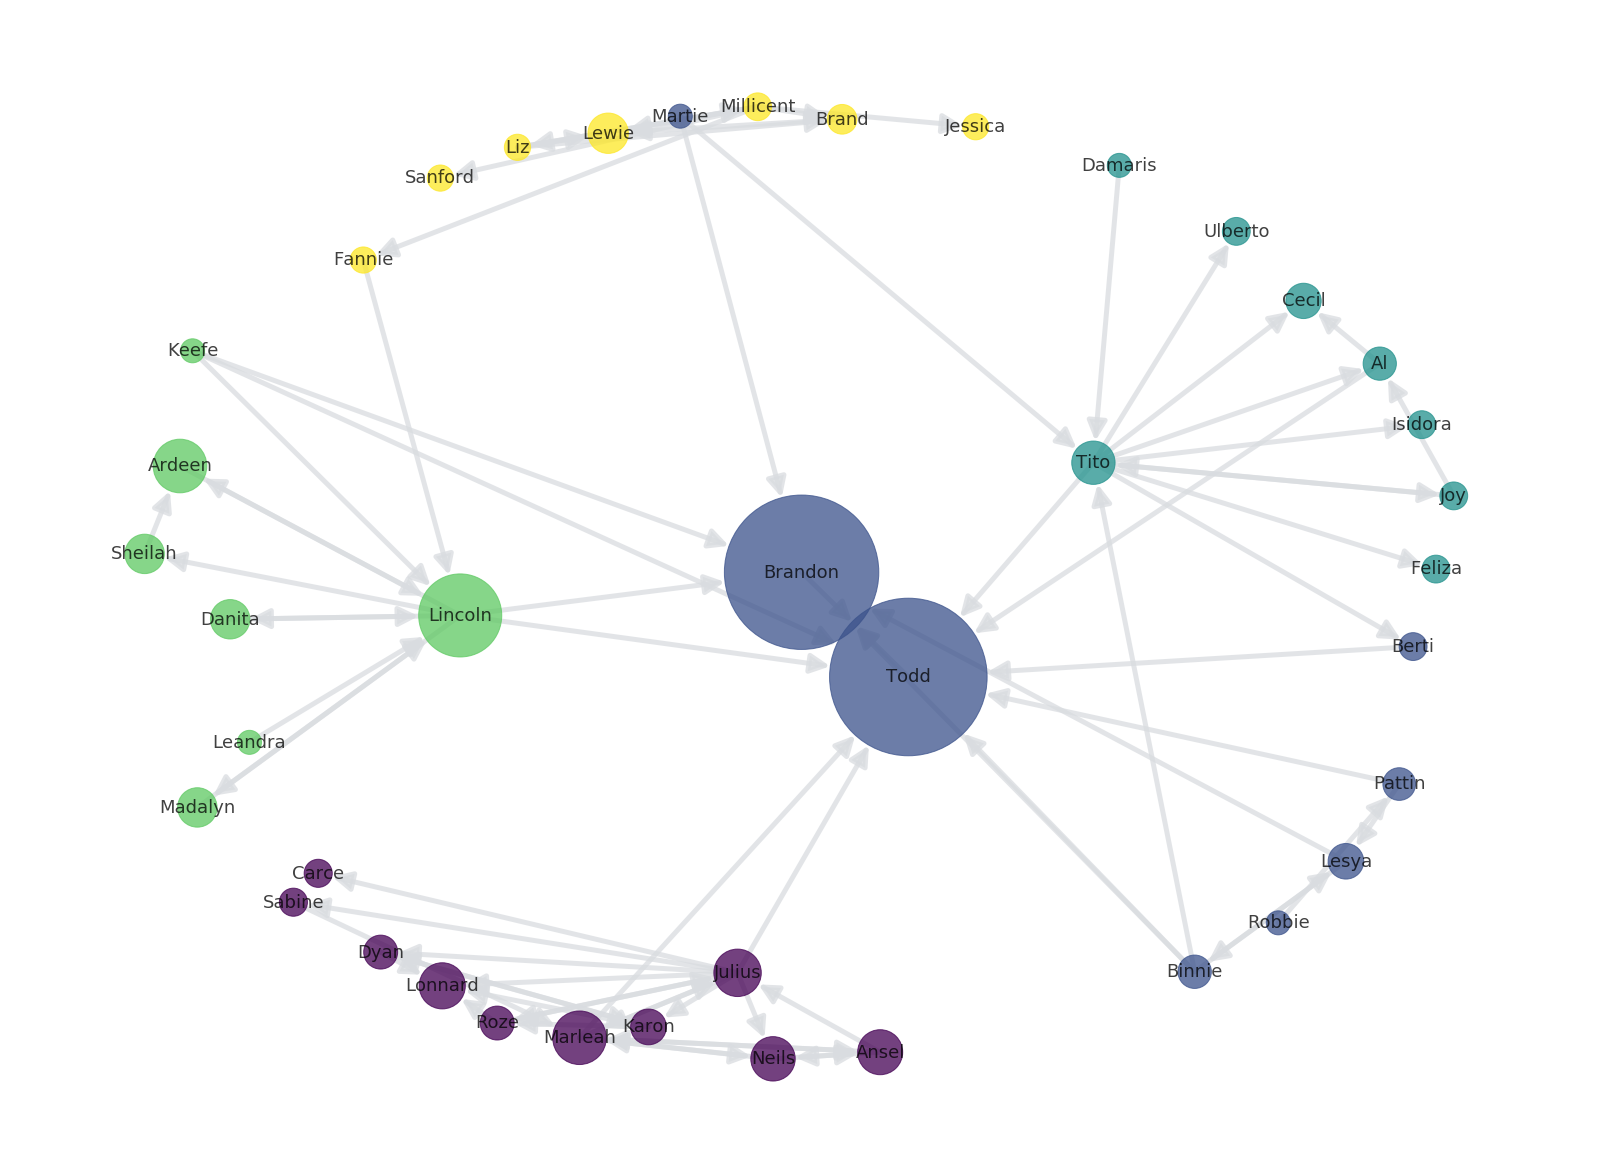

In [25]:
plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=18, 
        pos=pos,
        node_color=c_values,
        alpha=.75,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*pr[n] for n in Gsub.nodes()])

We see that nodes (e.g. Brandon and Todd) can be more/less important under different measures.

If we go back to our previous questions from the different teams, we can see network analysis has provided insight.

* Customer service team: who’s customer service call should we answer first?


* Marketing team: who should we spend our “influencers” marketing budget on?


* Product team: who should we recruit as a beta tester? Who are our power users?


* Customer research team: who should we interview?


### 🔙 Head back to the deck!

----
## Leftovers

Things that didn't make the cut to the final presentation.

#### HITS - Hubs and Authorities

In [26]:
# The HITS algorithm computes two numbers for a node.
# Authorities estimates the node value based on the incoming links.
# Hubs estimates the node value based on outgoing links.

hits = nx.hits(Gsub)  # returns (hubs, authorities)

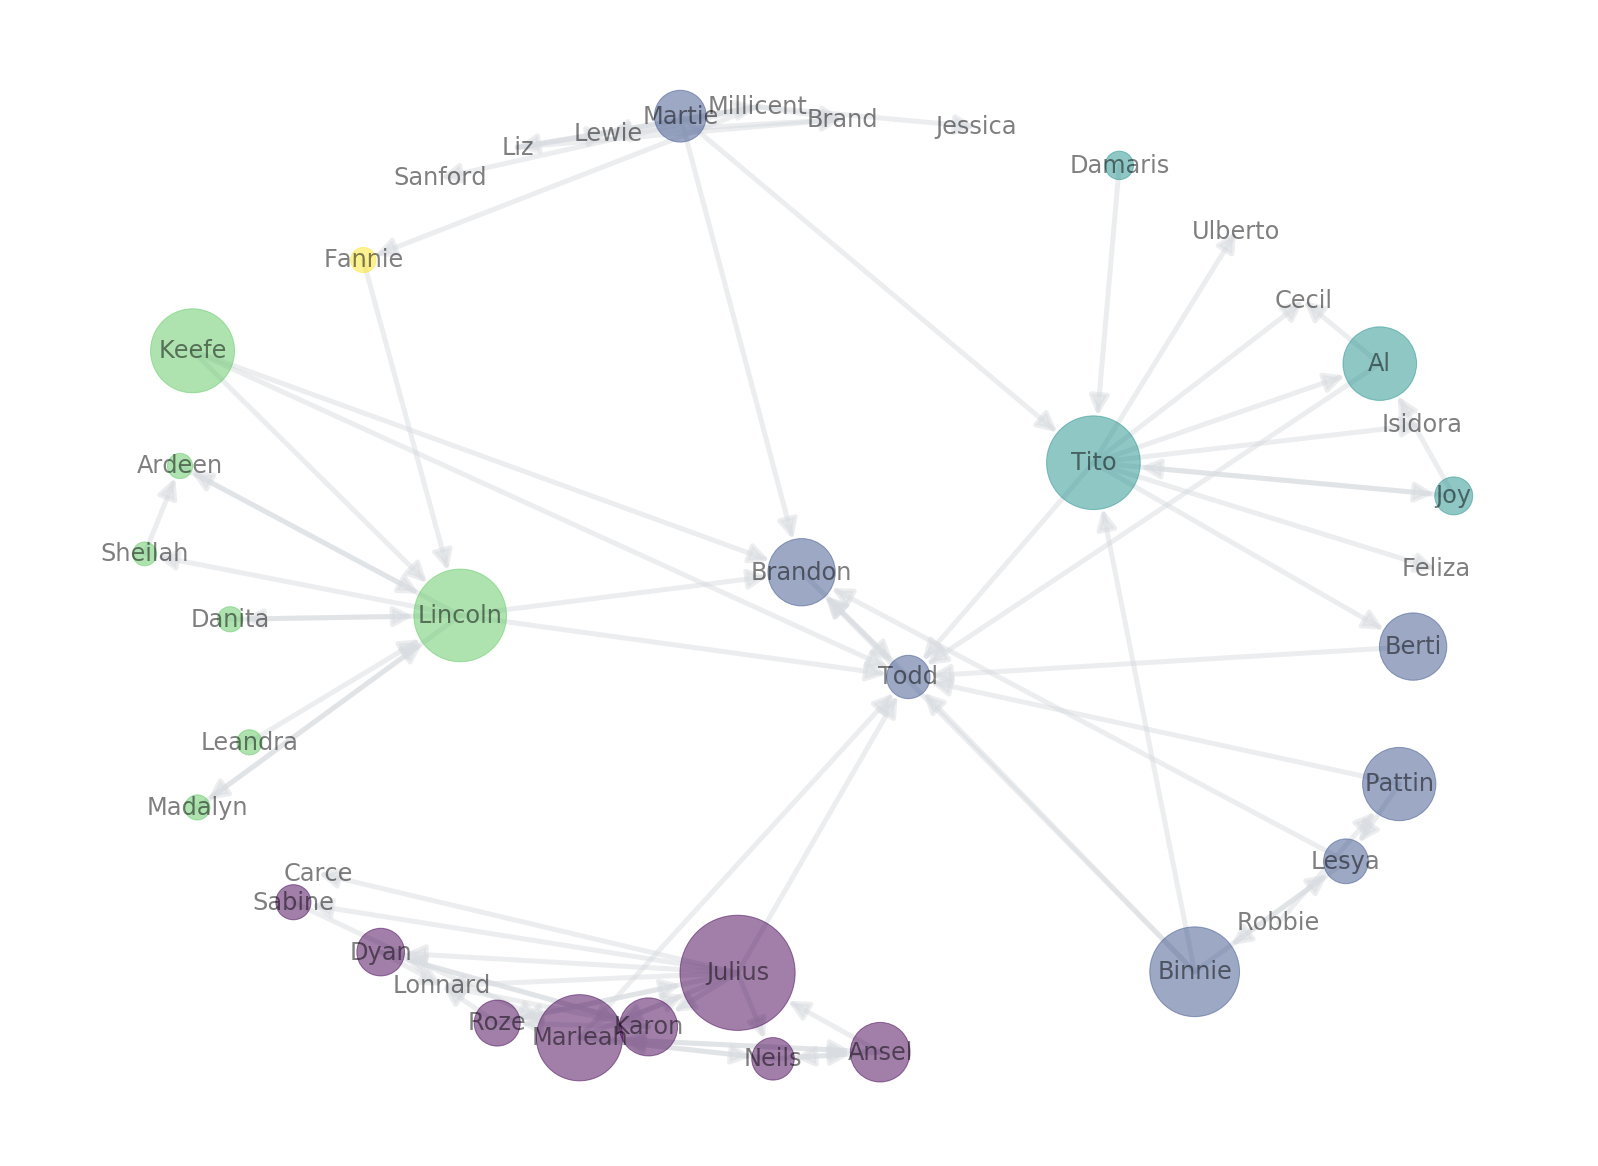

In [27]:
# Draw the graph according to Hubs - 
# Hubs estimates the node value based on outgoing links
# That is - nodes that send a lot of payments would be more prominent

plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=24,
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*hits[0][n] for n in Gsub.nodes()])

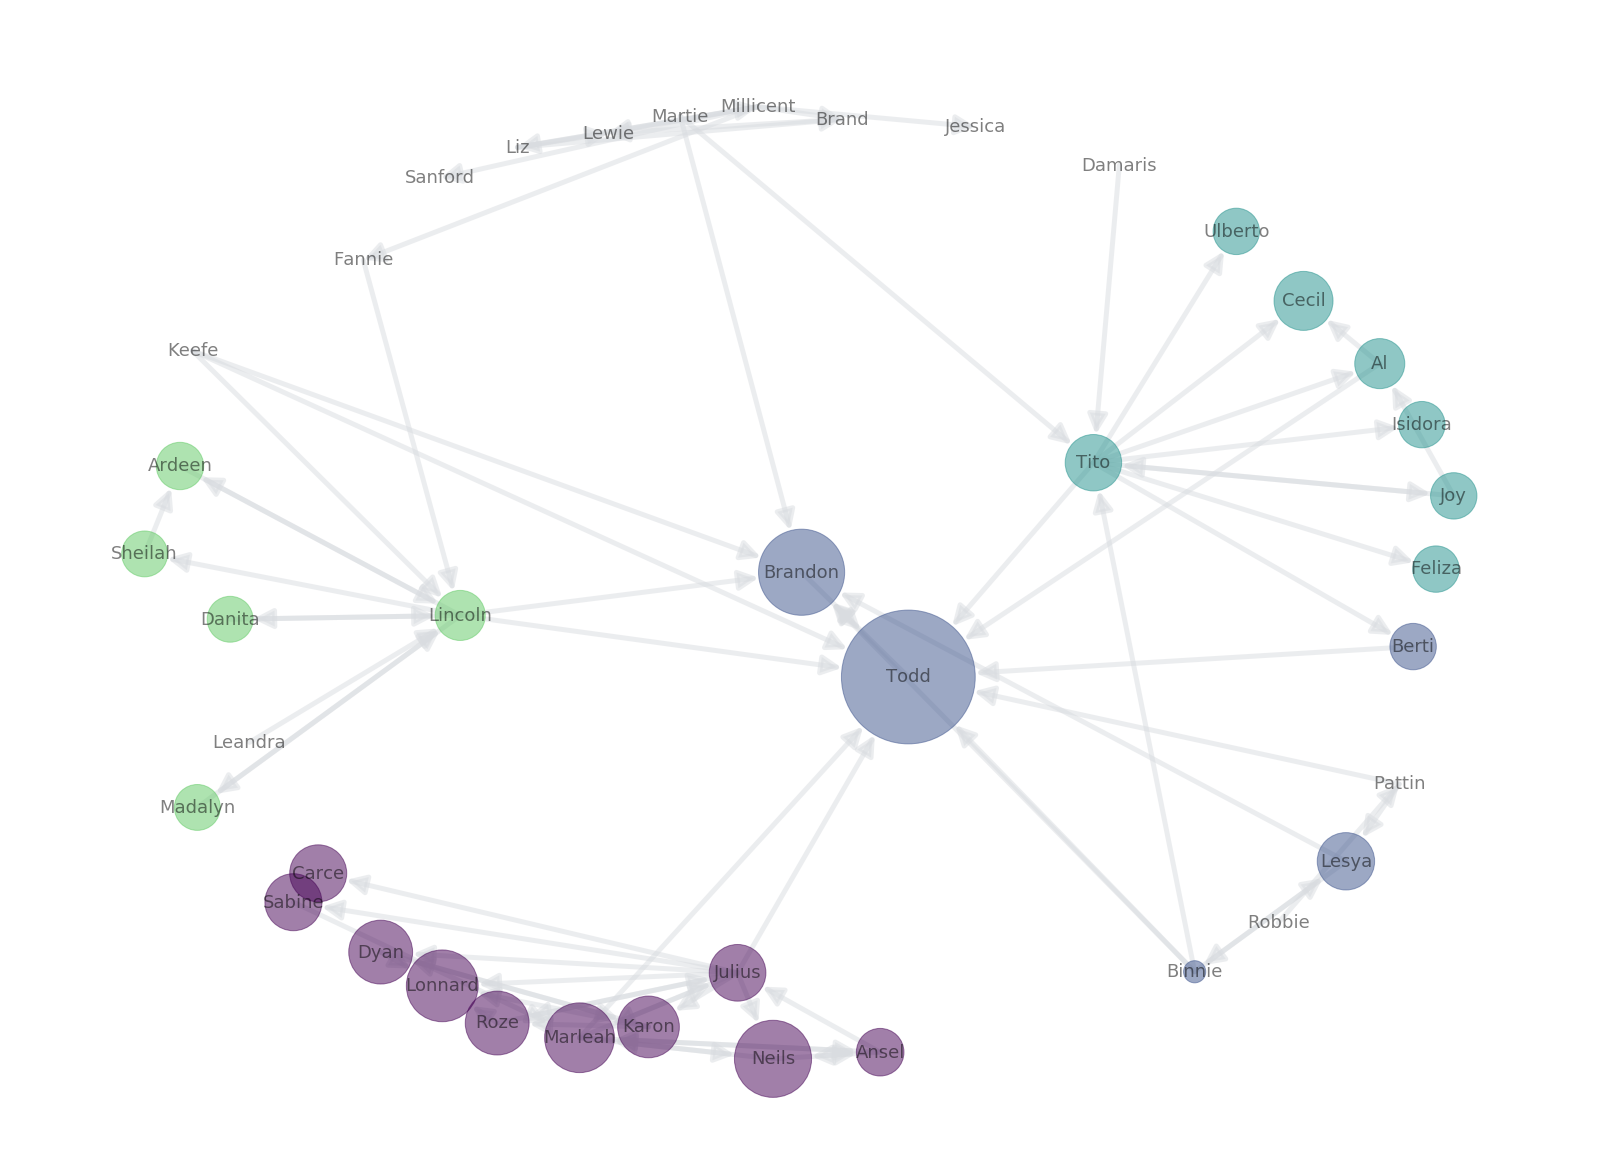

In [28]:
# Similarly with Authorities - 
# Authorities estimates the node value based on the incoming links
# That is - nodes that receive a lot of payments would be more prominent

plt.figure(figsize=(22,16))

nx.draw(Gsub, 
        edge_color='#d9dce0', 
        font_size=18, 
        pos=pos,
        node_color=c_values,
        alpha=.5,
        width=5,
        arrowsize = 40,
        labels=node_lables,
        with_labels=True,
        node_size=[100000*hits[1][n] for n in Gsub.nodes()])  # reminder: The HITS algorithm returns a tuple of (hubs, authorities)

See the differences in node sizes for hubs (outgoing links) and authorities (incoming).